# Illuminant Chromaticity Analysis for INTEL-TAU Nikon_D810

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import glob
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (14, 10)

# ========== GLOBAL SETTINGS ==========
# Adjust these settings to control color display throughout the notebook

# Scale colors to show hue more clearly (True recommended)
SCALE_BRIGHTNESS = True

# Brightness level (0.0 = very dim, 1.0 = full bright)
# Recommended: 0.6-0.8 for comfortable viewing
BRIGHTNESS_FACTOR = 0.7

In [27]:
# Load Nikon_D810 data (.wp white point files)
data_list = []

for wp_file in glob.glob("Data/Nikon_D810/**/*.wp", recursive=True):
    with open(wp_file, "r") as f:
        line = f.read().strip()
        values = line.replace("\t", " ").split()
        if len(values) >= 3:
            r, g, b = float(values[0]), float(values[1]), float(values[2])
            total = r + g + b
            if total > 0:  # Avoid division by zero
                folder_name = wp_file.split('/')[-2]
                data_list.append({
                    'mean_r': r/total,
                    'mean_g': g/total,
                    'mean_b': b/total,
                    'split': folder_name,
                    'source_file': wp_file.split('/')[-1]
                })

df = pd.DataFrame(data_list)
rgb_cols = ['mean_r', 'mean_g', 'mean_b']

print(f"Dataset: Nikon_D810")
print(f"Total samples: {len(df)}")
print(f"\nCategories: {df['split'].unique()}")
for category in df['split'].unique():
    count = len(df[df['split'] == category])
    print(f"  {category}: {count} samples")

unique_colors = len(df[rgb_cols].drop_duplicates())
print(f"\nUnique RGB combinations: {unique_colors}")

# Check if RGB values are chromaticity (should sum to 1.0)
df['rgb_sum'] = df['mean_r'] + df['mean_g'] + df['mean_b']
print(f"RGB Sum Statistics (should be ~1.0 if chromaticity):")
print(f"  Mean: {df['rgb_sum'].mean():.6f}")
print(f"  Min:  {df['rgb_sum'].min():.6f}")
print(f"  Max:  {df['rgb_sum'].max():.6f}")
print(f"  Std:  {df['rgb_sum'].std():.6f}")

# Show a few examples
print(f"\nFirst 5 samples:")
print(df[['mean_r', 'mean_g', 'mean_b', 'split', 'rgb_sum']].head())

# Check individual channel ranges
print(f"\nIndividual channel ranges:")
print(f"  R: [{df['mean_r'].min():.4f}, {df['mean_r'].max():.4f}]")
print(f"  G: [{df['mean_g'].min():.4f}, {df['mean_g'].max():.4f}]")
print(f"  B: [{df['mean_b'].min():.4f}, {df['mean_b'].max():.4f}]")

df.head()


Dataset: Nikon_D810
Total samples: 2793

Categories: ['field_1_cameras' 'lab_realscene' 'field_3_cameras' 'lab_printouts']
  field_1_cameras: 2329 samples
  lab_realscene: 20 samples
  field_3_cameras: 144 samples
  lab_printouts: 300 samples

Unique RGB combinations: 1614
RGB Sum Statistics (should be ~1.0 if chromaticity):
  Mean: 1.000000
  Min:  1.000000
  Max:  1.000000
  Std:  0.000000

First 5 samples:
     mean_r    mean_g    mean_b            split  rgb_sum
0  0.198720  0.434589  0.366691  field_1_cameras      1.0
1  0.211905  0.439194  0.348901  field_1_cameras      1.0
2  0.207732  0.445758  0.346510  field_1_cameras      1.0
3  0.220283  0.442127  0.337590  field_1_cameras      1.0
4  0.220937  0.441676  0.337388  field_1_cameras      1.0

Individual channel ranges:
  R: [0.0538, 0.5029]
  G: [0.2243, 0.5676]
  B: [0.0911, 0.6675]


,mean_r,mean_g,mean_b,split,source_file,rgb_sum
0,0.198720,0.434589,0.366691,field_1_cameras,N_D810_field_978.wp,1.0
1,0.211905,0.439194,0.348901,field_1_cameras,N_D810_field_1394.wp,1.0
2,0.207732,0.445758,0.346510,field_1_cameras,N_D810_field_1005.wp,1.0
3,0.220283,0.442127,0.337590,field_1_cameras,N_D810_field_1145.wp,1.0
4,0.220937,0.441676,0.337388,field_1_cameras,N_D810_field_838.wp,1.0


In [28]:
# OUTLIER DETECTION AND REMOVAL (THRESHOLD-BASED)

# Analyze current data distribution
print("=== CURRENT DATA DISTRIBUTION ===")
print(f"Total samples: {len(df)}")
print(f"R range: [{df['mean_r'].min():.4f}, {df['mean_r'].max():.4f}]")
print(f"G range: [{df['mean_g'].min():.4f}, {df['mean_g'].max():.4f}]")
print(f"B range: [{df['mean_b'].min():.4f}, {df['mean_b'].max():.4f}]")

# Check for extreme values (potential outliers)
print("\n=== POTENTIAL OUTLIERS (THRESHOLD METHOD) ===")

# Define thresholds for extreme values
r_threshold_high = 0.5  # Very high red values
r_threshold_low = 0.1   # Very low red values
b_threshold_high = 0.6  # Very high blue values
g_threshold_low = 0.3   # Very low green values

outliers_r_high = df[df['mean_r'] > r_threshold_high]
outliers_r_low = df[df['mean_r'] < r_threshold_low]
outliers_b_high = df[df['mean_b'] > b_threshold_high]
outliers_g_low = df[df['mean_g'] < g_threshold_low]

print(f"High red values (>{r_threshold_high}): {len(outliers_r_high)} samples")
print(f"Low red values (<{r_threshold_low}): {len(outliers_r_low)} samples")
print(f"High blue values (>{b_threshold_high}): {len(outliers_b_high)} samples")
print(f"Low green values (<{g_threshold_low}): {len(outliers_g_low)} samples")

# Calculate total potential outliers
total_potential_outliers = len(outliers_r_high) + len(outliers_r_low) + len(outliers_b_high) + len(outliers_g_low)
print(f"Total potential outliers: {total_potential_outliers} samples ({100*total_potential_outliers/len(df):.1f}%)")

# Remove outliers based on threshold method
print("\n=== REMOVING OUTLIERS (THRESHOLD METHOD) ===")
df_clean = df.copy()

# Remove outliers based on simple thresholds
original_count = len(df_clean)

df_clean = df_clean[df_clean['mean_r'] <= r_threshold_high]  # Remove very high red
df_clean = df_clean[df_clean['mean_r'] >= r_threshold_low]   # Remove very low red
df_clean = df_clean[df_clean['mean_b'] <= b_threshold_high]  # Remove very high blue
df_clean = df_clean[df_clean['mean_g'] >= g_threshold_low]   # Remove very low green

removed_count = original_count - len(df_clean)

print(f"Original dataset: {original_count} samples")
print(f"Cleaned dataset: {len(df_clean)} samples")
print(f"Removed: {removed_count} outliers ({100*removed_count/original_count:.1f}%)")

# Show cleaned data statistics
print("\n=== CLEANED DATA STATISTICS ===")
print(f"R range: [{df_clean['mean_r'].min():.4f}, {df_clean['mean_r'].max():.4f}]")
print(f"G range: [{df_clean['mean_g'].min():.4f}, {df_clean['mean_g'].max():.4f}]")
print(f"B range: [{df_clean['mean_b'].min():.4f}, {df_clean['mean_b'].max():.4f}]")

# Camera breakdown after cleaning (if multi-camera data)
if 'camera' in df_clean.columns:
    print("Camera breakdown (cleaned):")
    for camera in df_clean['camera'].unique():
        count = len(df_clean[df_clean['camera'] == camera])
        print(f"  {camera}: {count} samples")

# Replace df with cleaned version
print("\n=== UPDATING DF WITH CLEANED DATA ===")
df = df_clean.copy()
print(f"Dataset updated! Now contains {len(df)} samples after threshold-based outlier removal.")

=== CURRENT DATA DISTRIBUTION ===
Total samples: 2793
R range: [0.0538, 0.5029]
G range: [0.2243, 0.5676]
B range: [0.0911, 0.6675]

=== POTENTIAL OUTLIERS (THRESHOLD METHOD) ===
High red values (>0.5): 1 samples
Low red values (<0.1): 1 samples
High blue values (>0.6): 2 samples
Low green values (<0.3): 2 samples
Total potential outliers: 6 samples (0.2%)

=== REMOVING OUTLIERS (THRESHOLD METHOD) ===
Original dataset: 2793 samples
Cleaned dataset: 2790 samples
Removed: 3 outliers (0.1%)

=== CLEANED DATA STATISTICS ===
R range: [0.1461, 0.5000]
G range: [0.3872, 0.5676]
B range: [0.0911, 0.4466]

=== UPDATING DF WITH CLEANED DATA ===
Dataset updated! Now contains 2790 samples after threshold-based outlier removal.


## 2. RG Chromaticity Diagram with Color Buckets

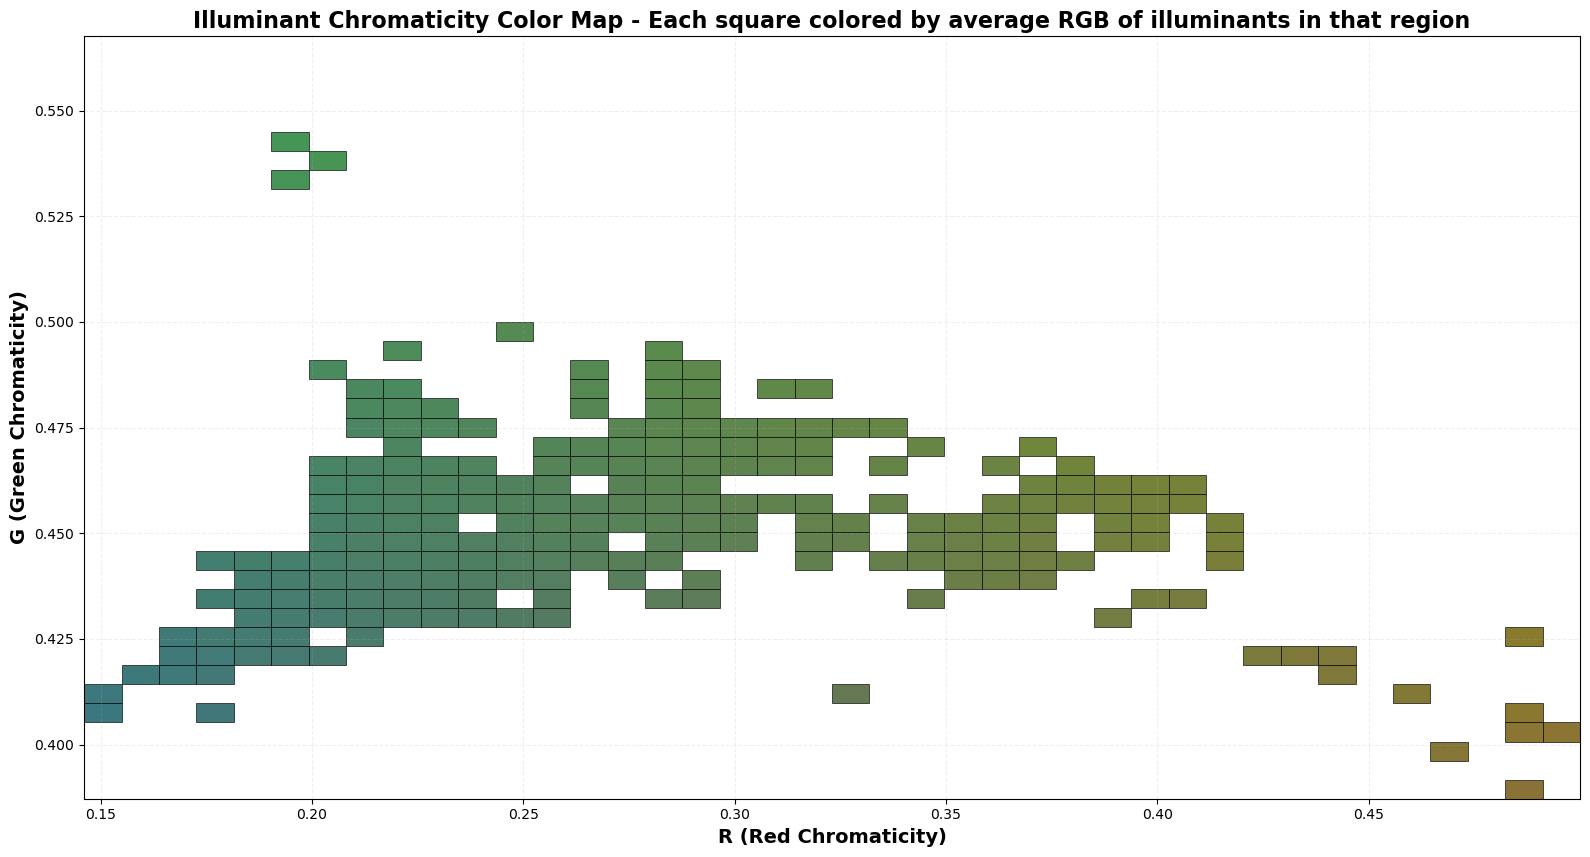

Avg samples per non-empty bin: 12.4


In [29]:
# Extract RGB chromaticity
r = df['mean_r'].values
g = df['mean_g'].values
b = df['mean_b'].values

# Create bins
n_bins = 40  # Number of bins in each direction

# Define bin edges
r_bins = np.linspace(r.min(), r.max(), n_bins + 1)
g_bins = np.linspace(g.min(), g.max(), n_bins + 1)

# Create figure
fig, ax = plt.subplots(figsize=(16, 14))

# For each bin, compute average RGB and draw colored rectangle
for i in range(n_bins):
    for j in range(n_bins):
        # Find points in this bin
        mask = ((r >= r_bins[i]) & (r < r_bins[i+1]) & 
                (g >= g_bins[j]) & (g < g_bins[j+1]))
        
        if mask.sum() > 0:  # If there are points in this bin
            # Compute average RGB
            avg_r = r[mask].mean()
            avg_g = g[mask].mean()
            avg_b = b[mask].mean()
            
            # Normalize (ensure sum = 1)
            total = avg_r + avg_g + avg_b
            color = [avg_r/total, avg_g/total, avg_b/total]
            
            # Draw rectangle
            rect = patches.Rectangle((r_bins[i], g_bins[j]), 
                                     r_bins[i+1] - r_bins[i],
                                     g_bins[j+1] - g_bins[j],
                                     linewidth=0.5, edgecolor="black",
                                     facecolor=color, alpha=0.9)
            ax.add_patch(rect)

ax.set_xlim(r.min(), r.max())
ax.set_ylim(g.min(), g.max())
ax.set_xlabel("R (Red Chromaticity)", fontsize=14, fontweight="bold")
ax.set_ylabel("G (Green Chromaticity)", fontsize=14, fontweight="bold")
ax.set_title(f"Illuminant Chromaticity Color Map - Each square colored by average RGB of illuminants in that region", 
             fontsize=16, fontweight="bold")
ax.grid(True, alpha=0.2, linestyle="--")
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

# Count non-empty bins
non_empty = 0
for i in range(n_bins):
    for j in range(n_bins):
        mask = ((r >= r_bins[i]) & (r < r_bins[i+1]) & 
                (g >= g_bins[j]) & (g < g_bins[j+1]))
        if mask.sum() > 0:
            non_empty += 1

print(f"Avg samples per non-empty bin: {len(df)/non_empty:.1f}")

## 3. Scatter Plot - All Points Colored by RGB

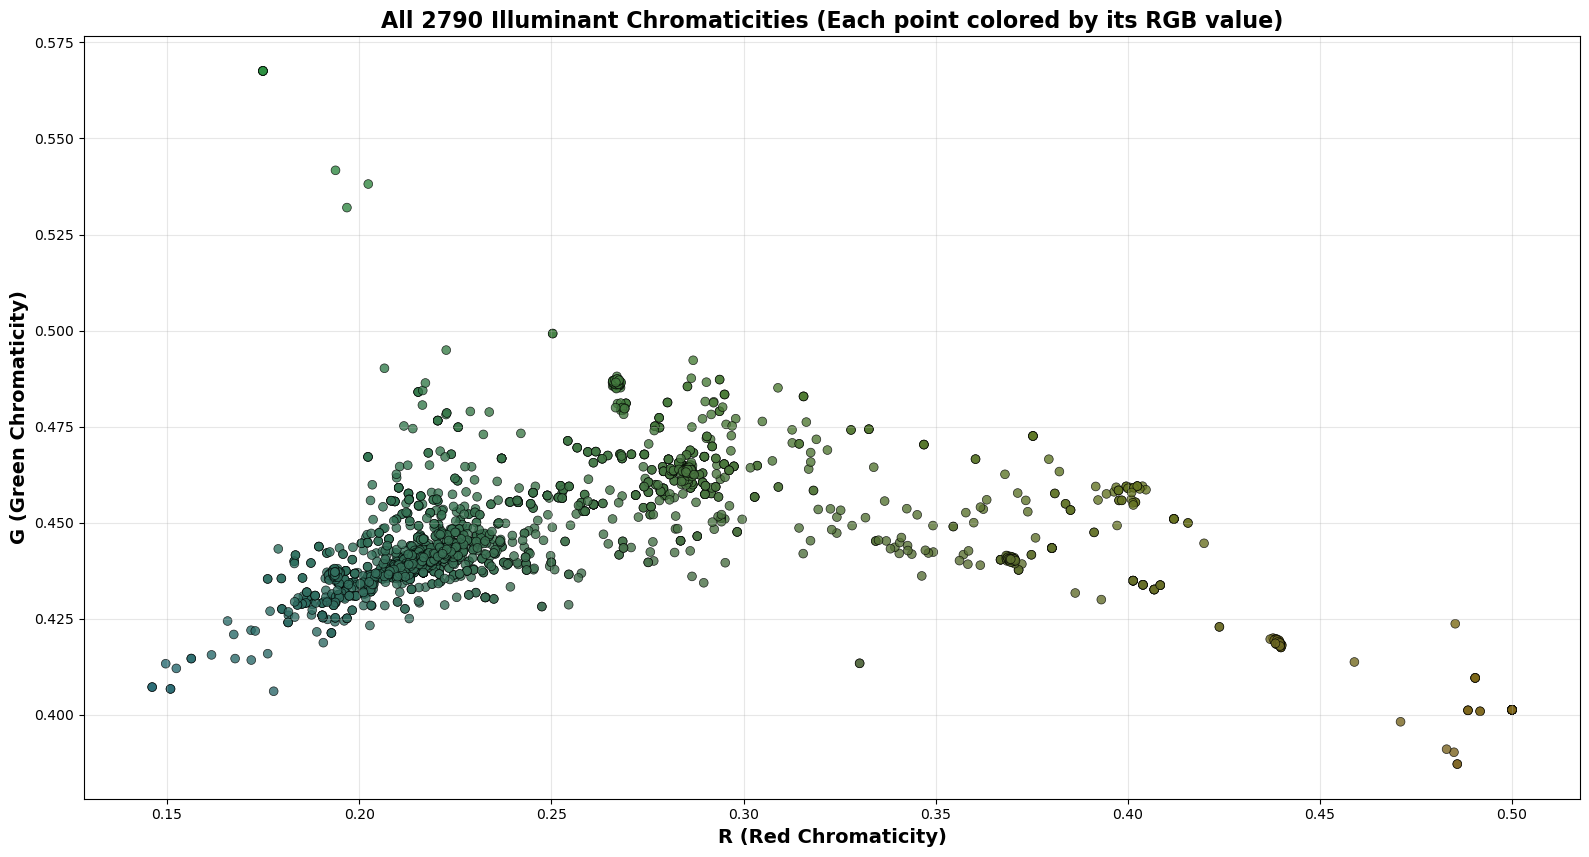

In [30]:
# Individual scatter plot
fig, ax = plt.subplots(figsize=(16, 14))

# Create color array
point_colors = np.column_stack([r, g, b])

# Scatter
scatter = ax.scatter(r, g, c=point_colors, s=40, alpha=0.8, 
                     edgecolors="black", linewidths=0.5)

ax.set_xlabel("R (Red Chromaticity)", fontsize=14, fontweight="bold")
ax.set_ylabel("G (Green Chromaticity)", fontsize=14, fontweight="bold")
ax.set_title(f"All {len(df)} Illuminant Chromaticities (Each point colored by its RGB value)", 
             fontsize=16, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

## 4. Distribution Analysis

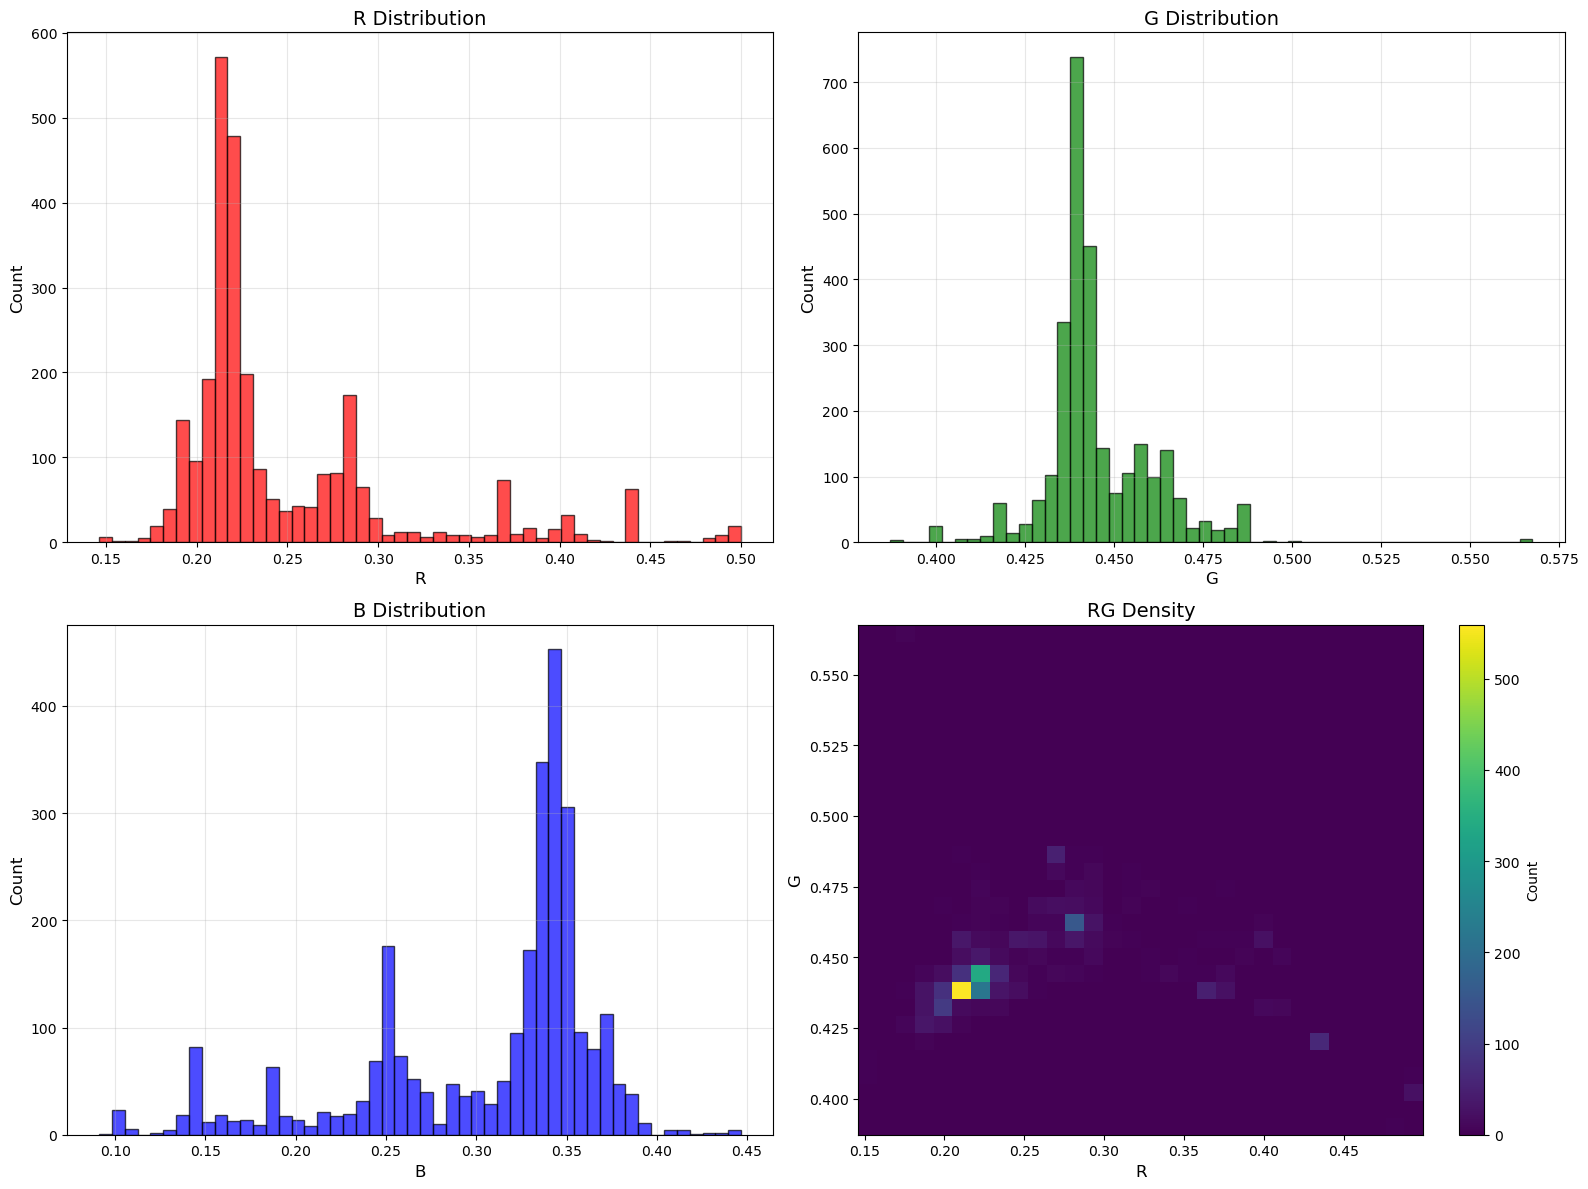

In [31]:
# Analyze the distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R distribution
axes[0, 0].hist(r, bins=50, color="red", alpha=0.7, edgecolor="black")
axes[0, 0].set_xlabel("R", fontsize=12)
axes[0, 0].set_ylabel("Count", fontsize=12)
axes[0, 0].set_title("R Distribution", fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# G distribution
axes[0, 1].hist(g, bins=50, color="green", alpha=0.7, edgecolor="black")
axes[0, 1].set_xlabel("G", fontsize=12)
axes[0, 1].set_ylabel("Count", fontsize=12)
axes[0, 1].set_title("G Distribution", fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# B distribution
axes[1, 0].hist(b, bins=50, color="blue", alpha=0.7, edgecolor="black")
axes[1, 0].set_xlabel("B", fontsize=12)
axes[1, 0].set_ylabel("Count", fontsize=12)
axes[1, 0].set_title("B Distribution", fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# 2D density
h = axes[1, 1].hist2d(r, g, bins=30, cmap="viridis")
axes[1, 1].set_xlabel("R", fontsize=12)
axes[1, 1].set_ylabel("G", fontsize=12)
axes[1, 1].set_title("RG Density", fontsize=14)
plt.colorbar(h[3], ax=axes[1, 1], label="Count")

plt.tight_layout()
plt.show()

## 5. K-Means Clustering Analysis

Silhouette Score: measures how well-separated and compact the clusters are. Higher = better separation between clusters.

Inertia (within-cluster sum of squares): used for the elbow method. Lower inertia = tighter clusters (but always decreases as k increases).

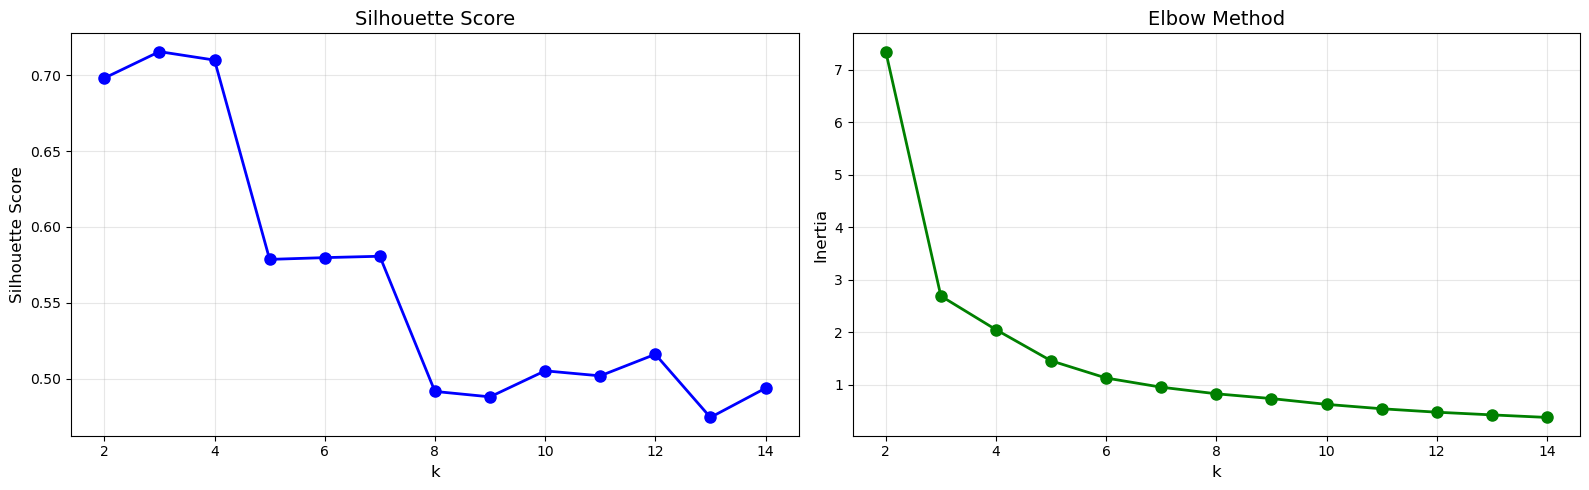

In [32]:
# Test different k values
X = df[rgb_cols].values
k_range = range(2, 15)
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    silhouette_scores.append(sil)
    inertias.append(kmeans.inertia_)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(k_range, silhouette_scores, "bo-", linewidth=2, markersize=8)
axes[0].set_xlabel("k", fontsize=12)
axes[0].set_ylabel("Silhouette Score", fontsize=12)
axes[0].set_title("Silhouette Score", fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, inertias, "go-", linewidth=2, markersize=8)
axes[1].set_xlabel("k", fontsize=12)
axes[1].set_ylabel("Inertia", fontsize=12)
axes[1].set_title("Elbow Method", fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Compare Different k Values

Let's visualize what different cluster counts look like:

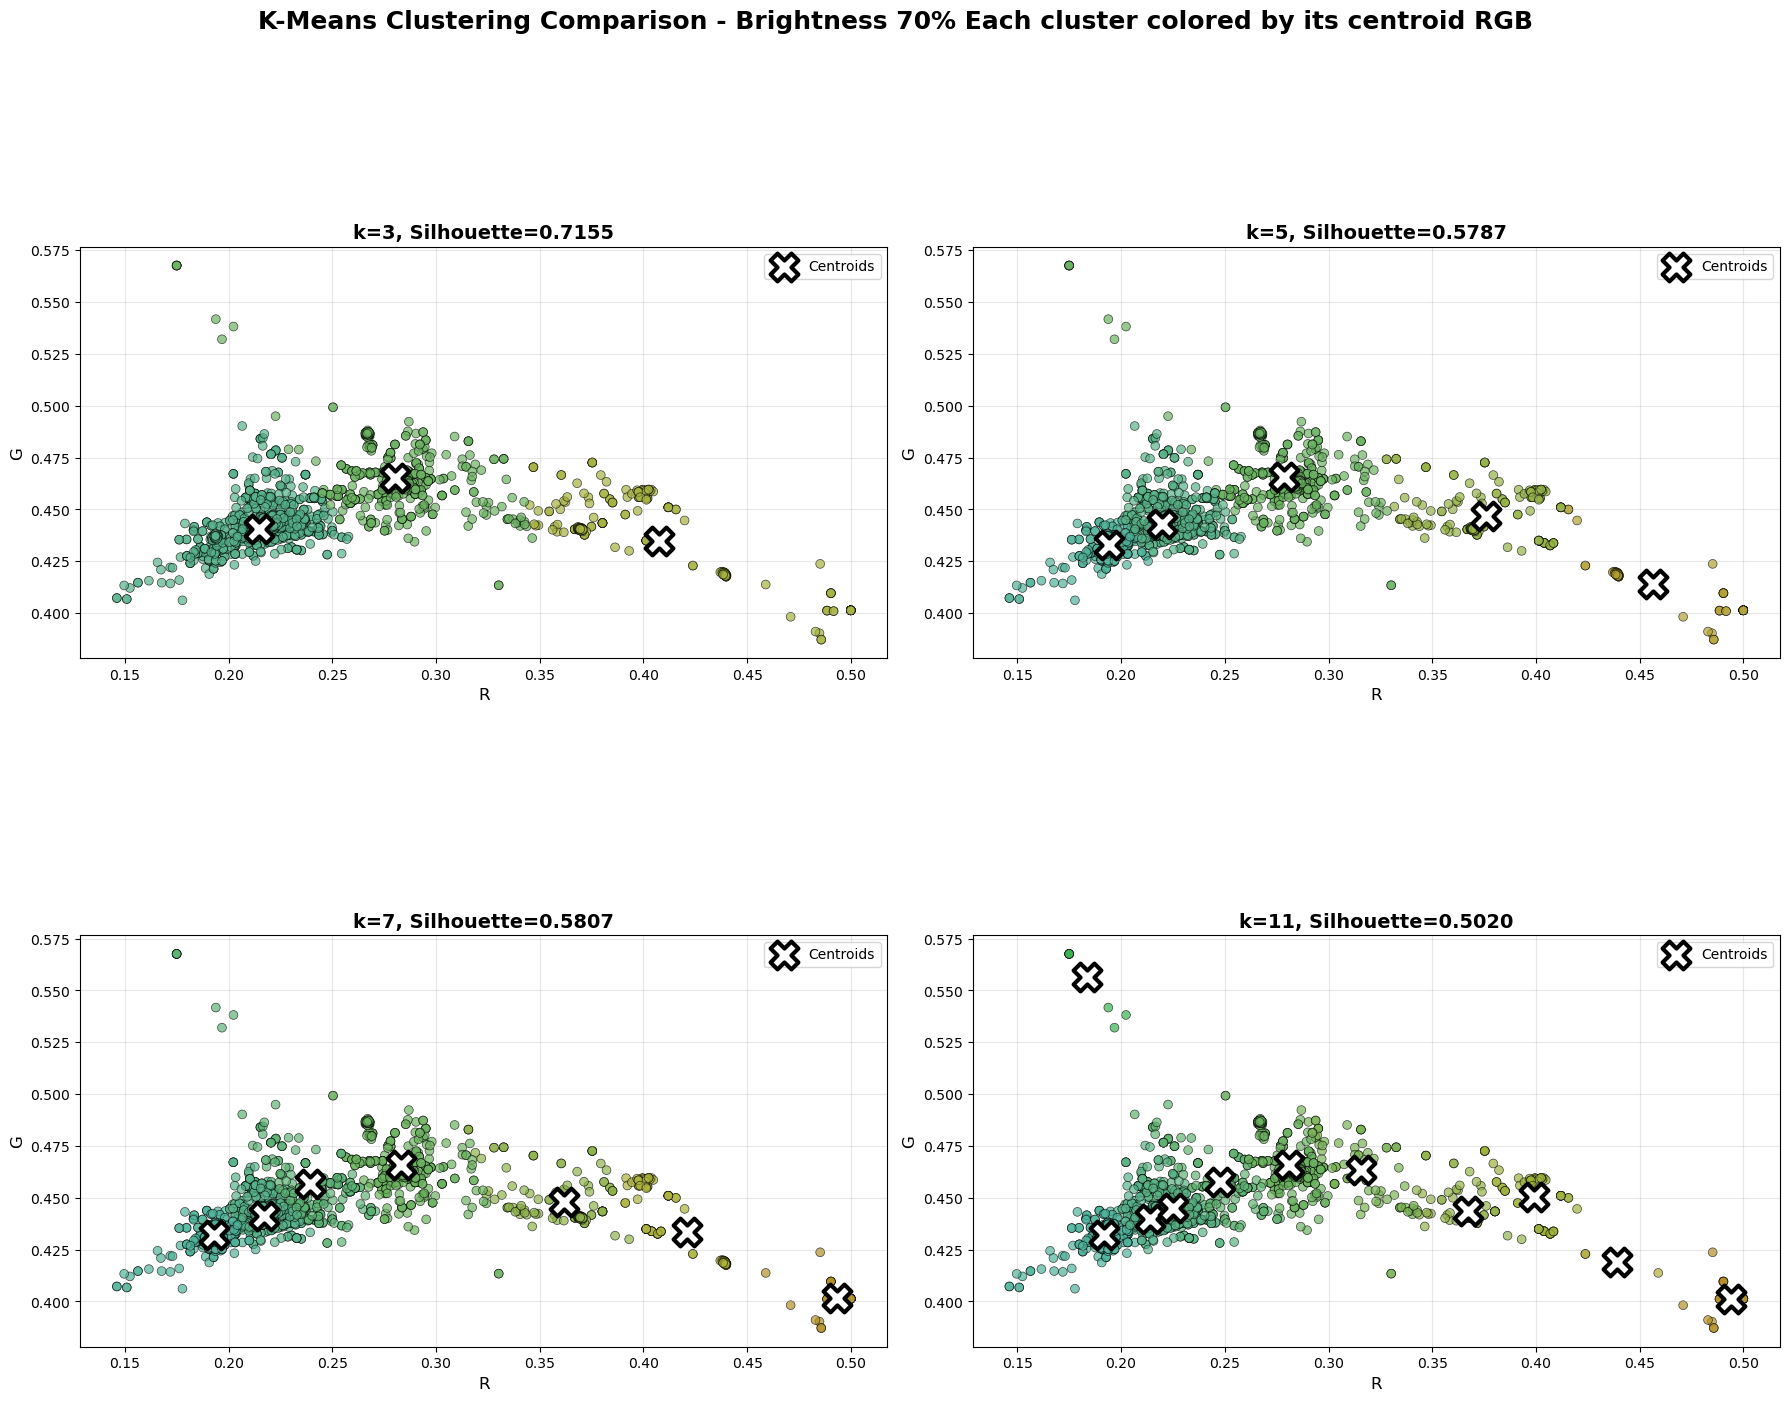

In [33]:
# Compare different k values side-by-side
k_values = [3, 5, 7, 11]

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    
    # Color each point by its cluster's centroid RGB
    centroids = kmeans.cluster_centers_
    point_colors = []
    for cluster_id in labels:
        centroid_rgb = centroids[cluster_id].copy()
        
        if SCALE_BRIGHTNESS:
            max_val = centroid_rgb.max()
            if max_val > 0:
                centroid_rgb = (centroid_rgb / max_val) * BRIGHTNESS_FACTOR
        
        centroid_rgb = np.clip(centroid_rgb, 0, 1)
        point_colors.append(centroid_rgb)
    point_colors = np.array(point_colors)
    
    # Plot
    ax = axes[idx]
    scatter = ax.scatter(r, g, c=point_colors, s=40, alpha=0.7,
                        edgecolors="black", linewidths=0.5)
    
    # Centroids
    ax.scatter(centroids[:, 0], centroids[:, 1],
              c="white", marker="X", s=400, edgecolors="black", linewidth=3,
              label="Centroids", zorder=10)
    
    ax.set_xlabel("R", fontsize=12)
    ax.set_ylabel("G", fontsize=12)
    ax.set_title(f"k={k}, Silhouette={sil:.4f}", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")
    ax.set_aspect("equal", adjustable="box")

mode_text = f"Brightness {int(BRIGHTNESS_FACTOR*100)}%" if SCALE_BRIGHTNESS else "Actual Chromaticity"
plt.suptitle(f"K-Means Clustering Comparison - {mode_text} Each cluster colored by its centroid RGB", 
             fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

## 7. Set k Value

**Based on the comparisons above, choosing the k:**

In [34]:
best_k = 5

print(f"Using k={best_k} clusters for detailed analysis")

Using k=5 clusters for detailed analysis


## 8. Detailed Analysis for chosen k

Using global brightness settings: 70%


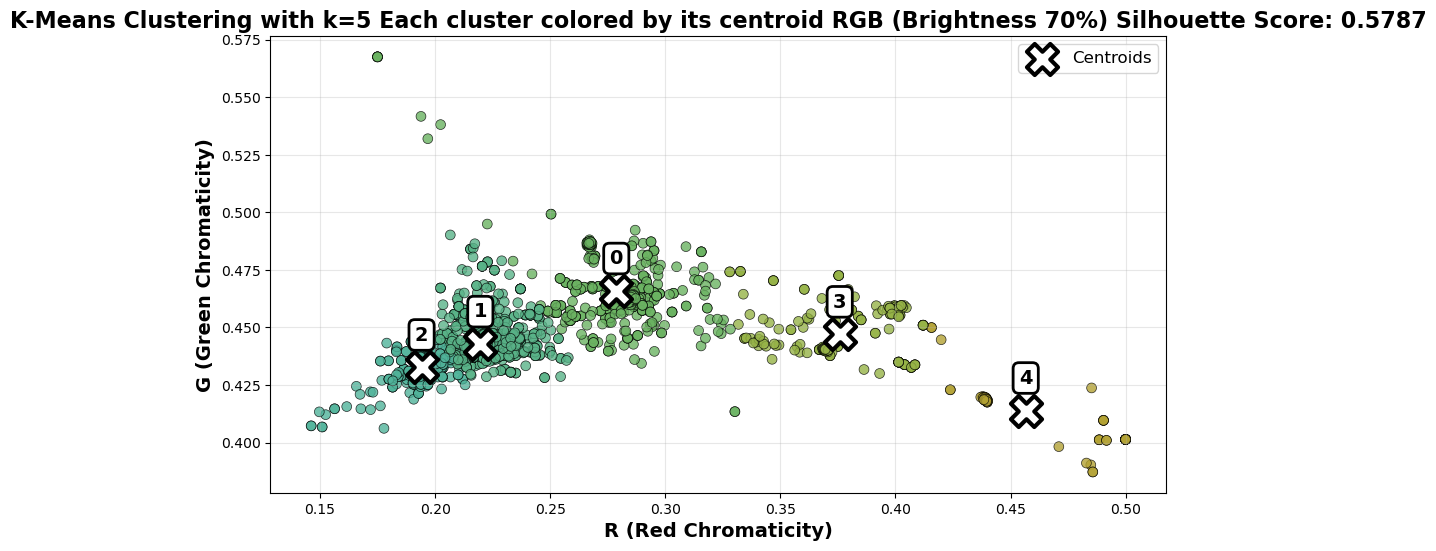

Finding extreme colors for each cluster...


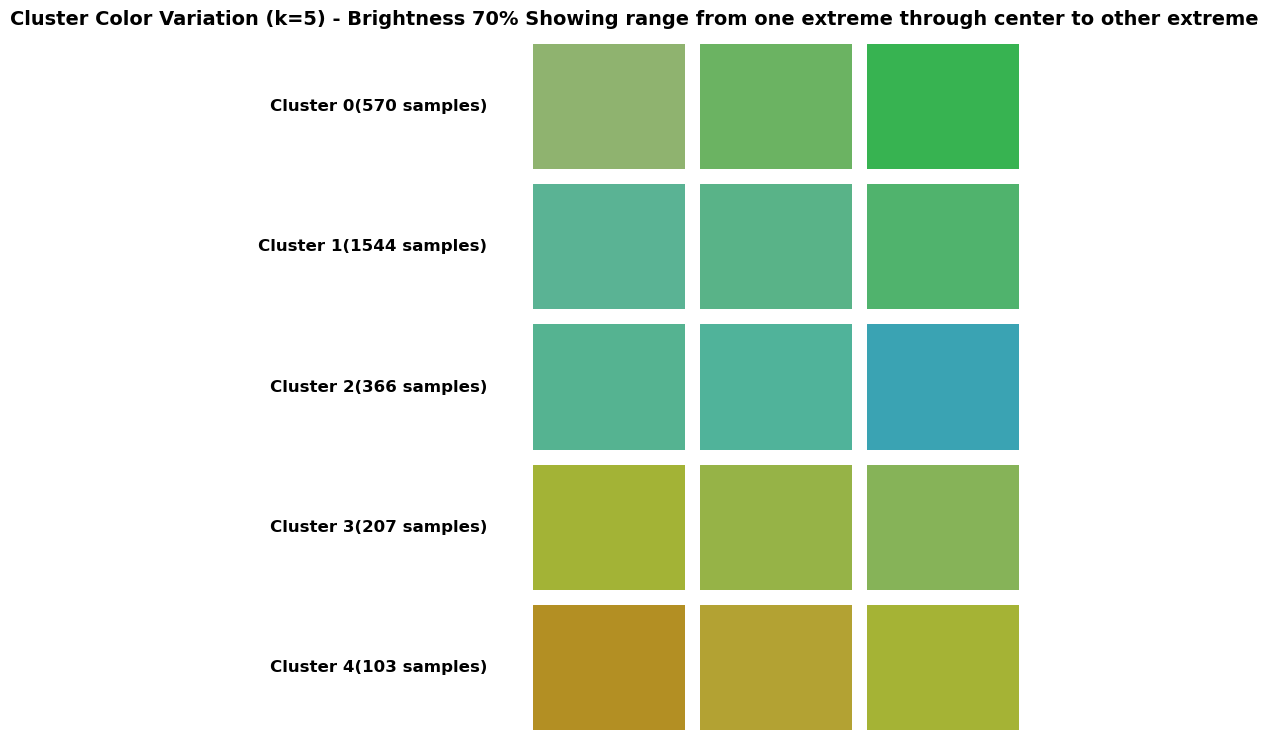

Cluster Statistics:
Cluster 0:
  Size: 570 (20.4%)
  Centroid (chromaticity): R=0.2787, G=0.4658, B=0.2555
  Spread (avg distance from centroid): 0.0233
  Spread (max distance from centroid): 0.1453
  R range: [0.1749, 0.3302]
  G range: [0.4134, 0.5676]
  B range: [0.2015, 0.2957]
Cluster 1:
  Size: 1544 (55.3%)
  Centroid (chromaticity): R=0.2196, G=0.4427, B=0.3376
  Spread (avg distance from centroid): 0.0131
  Spread (max distance from centroid): 0.0601
  R range: [0.2017, 0.2578]
  G range: [0.4282, 0.4902]
  B range: [0.2921, 0.3561]
Cluster 2:
  Size: 366 (13.1%)
  Centroid (chromaticity): R=0.1941, G=0.4326, B=0.3733
  Spread (avg distance from centroid): 0.0135
  Spread (max distance from centroid): 0.0912
  R range: [0.1461, 0.2130]
  G range: [0.4062, 0.4447]
  B range: [0.3548, 0.4466]
Cluster 3:
  Size: 207 (7.4%)
  Centroid (chromaticity): R=0.3758, G=0.4470, B=0.1772
  Spread (avg distance from centroid): 0.0289
  Spread (max distance from centroid): 0.0598
  R range: [

In [35]:
# Perform clustering with chosen k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

print(f"Using global brightness settings: {int(BRIGHTNESS_FACTOR*100)}%")

# Visualize the clustering with clusters colored by their centroid RGB
fig, ax = plt.subplots(figsize=(10, 6))

# Create colors for each point based on cluster centroid
centroids = kmeans.cluster_centers_
point_colors = []
for i, cluster_id in enumerate(df['cluster']):
    centroid_rgb = centroids[cluster_id].copy()
    
    if SCALE_BRIGHTNESS:
        max_val = centroid_rgb.max()
        if max_val > 0:
            centroid_rgb = (centroid_rgb / max_val) * BRIGHTNESS_FACTOR
    
    centroid_rgb = np.clip(centroid_rgb, 0, 1)
    point_colors.append(centroid_rgb)
point_colors = np.array(point_colors)

# Scatter plot with actual RGB colors
scatter = ax.scatter(r, g, c=point_colors, s=50, alpha=0.8,
                    edgecolors="black", linewidths=0.5)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1],
          c="white", marker="X", s=500, edgecolors="black", linewidth=3,
          label="Centroids", zorder=10)

# Label centroids with their cluster ID
for i, centroid in enumerate(centroids):
    ax.text(centroid[0], centroid[1]+0.01, f"{i}", fontsize=14, fontweight="bold",
           ha="center", va="bottom", color="black",
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", linewidth=2))

ax.set_xlabel("R (Red Chromaticity)", fontsize=14, fontweight="bold")
ax.set_ylabel("G (Green Chromaticity)", fontsize=14, fontweight="bold")
ax.set_title(f"K-Means Clustering with k={best_k} Each cluster colored by its centroid RGB (Brightness {int(BRIGHTNESS_FACTOR*100)}%) Silhouette Score: {silhouette_scores[best_k-2]:.4f}",
             fontsize=16, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

# Show cluster representative colors: MIN, CENTER, MAX
print("Finding extreme colors for each cluster...")
fig, axes = plt.subplots(best_k, 3, figsize=(8, 1.5*best_k))
if best_k == 1:
    axes = axes.reshape(1, 3)

for i in range(best_k):
    cluster_mask = df['cluster'] == i
    cluster_data = X[cluster_mask]
    centroid = kmeans.cluster_centers_[i]
    
    # Find distances from centroid
    distances = np.linalg.norm(cluster_data - centroid, axis=1)
    
    # Find point closest to centroid (most representative)
    closest_idx = np.argmin(distances)
    closest_point = cluster_data[closest_idx]
    
    # Find point farthest from centroid
    farthest_idx = np.argmax(distances)
    farthest_point = cluster_data[farthest_idx]
    
    # For "other extreme", find point that's far but in opposite direction
    # Use the point that has maximum negative dot product with (farthest - centroid)
    if len(cluster_data) > 2:
        direction = farthest_point - centroid
        projections = np.dot(cluster_data - centroid, direction)
        opposite_idx = np.argmin(projections)
        opposite_point = cluster_data[opposite_idx]
    else:
        opposite_point = closest_point
    
    # Display the three colors
    points = [opposite_point, centroid, farthest_point]
    
    for j, (point, label) in enumerate(zip(points, labels)):
        color = point.copy()
        
        if SCALE_BRIGHTNESS:
            max_val = color.max()
            if max_val > 0:
                color = (color / max_val) * BRIGHTNESS_FACTOR
        
        color = np.clip(color, 0, 1)
        
        axes[i, j].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
        axes[i, j].set_xlim(0, 1)
        axes[i, j].set_ylim(0, 1)
        axes[i, j].axis("off")
        
        # Show RGB values
        orig = points[j]
    
    # Add cluster label on the left
    axes[i, 0].text(-0.3, 0.5, f"Cluster {i}({cluster_mask.sum()} samples)", 
                    transform=axes[i, 0].transAxes,
                    fontsize=12, fontweight="bold", va="center", ha="right")

plt.suptitle(f"Cluster Color Variation (k={best_k}) - Brightness {int(BRIGHTNESS_FACTOR*100)}% Showing range from one extreme through center to other extreme", 
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print detailed statistics
print("Cluster Statistics:")
print("="*80)
for i in range(best_k):
    cluster_df = df[df['cluster'] == i]
    cluster_data = X[df['cluster'] == i]
    centroid = kmeans.cluster_centers_[i]
    
    # Calculate spread
    distances = np.linalg.norm(cluster_data - centroid, axis=1)
    
    print(f"Cluster {i}:")
    print(f"  Size: {len(cluster_df)} ({100*len(cluster_df)/len(df):.1f}%)")
    print(f"  Centroid (chromaticity): R={centroid[0]:.4f}, G={centroid[1]:.4f}, B={centroid[2]:.4f}")
    print(f"  Spread (avg distance from centroid): {distances.mean():.4f}")
    print(f"  Spread (max distance from centroid): {distances.max():.4f}")
    print(f"  R range: [{cluster_df['mean_r'].min():.4f}, {cluster_df['mean_r'].max():.4f}]")
    print(f"  G range: [{cluster_df['mean_g'].min():.4f}, {cluster_df['mean_g'].max():.4f}]")
    print(f"  B range: [{cluster_df['mean_b'].min():.4f}, {cluster_df['mean_b'].max():.4f}]")


In [36]:
# Create a systematic naming scheme
cluster_names = {   
    4: " Very Warm",           
    1: "Cool",  
    2: "Very Cool",      
    0: "Neutral",       
    3: "Warm",
}

# Print summary
print("="*80)
print("Cluster     Name                                B/R Ratio    Centroid RGB")
print("-"*80)

# Sort by B/R ratio (warm to cool)
sorted_clusters = sorted(range(5), key=lambda i: kmeans.cluster_centers_[i][2] / kmeans.cluster_centers_[i][0])

for cluster_id in sorted_clusters:
    centroid = kmeans.cluster_centers_[cluster_id]
    r, g, b = centroid
    br_ratio = b / r
    name = cluster_names[cluster_id]
    
    cluster_size = np.sum(df["cluster"] == cluster_id)
    pct = 100 * cluster_size / len(df)
    
    print(f"{cluster_id:<10} {name:<35} {br_ratio:<12.3f} [{r:.3f}, {g:.3f}, {b:.3f}]")
    print(f"           ↳ {cluster_size} samples ({pct:.1f}%)")
    print()

Cluster     Name                                B/R Ratio    Centroid RGB
--------------------------------------------------------------------------------
4           Very Warm                          0.284        [0.457, 0.414, 0.129]
           ↳ 103 samples (3.7%)

3          Warm                                0.472        [0.376, 0.447, 0.177]
           ↳ 207 samples (7.4%)

0          Neutral                             0.917        [0.279, 0.466, 0.255]
           ↳ 570 samples (20.4%)

1          Cool                                1.537        [0.220, 0.443, 0.338]
           ↳ 1544 samples (55.3%)

2          Very Cool                           1.923        [0.194, 0.433, 0.373]
           ↳ 366 samples (13.1%)



In [37]:
# Save cluster centers for use later
# ['Cool', 'Neutral', 'Very_Cool', 'Very_Warm', 'Warm']

# Get cluster centers from kmeans
centroids = kmeans.cluster_centers_

# Create mapping: sorted by B/R ratio (warm to cool) -> class names
sorted_clusters = sorted(range(5), key=lambda i: centroids[i][2] / centroids[i][0])
label_template = ["Very_Warm", "Warm", "Neutral", "Cool", "Very_Cool"]

cluster_centers_dict = {}
for rank, cluster_id in enumerate(sorted_clusters):
    class_name = label_template[rank] if rank < len(label_template) else f"Cluster_{rank}"
    cluster_centers_dict[class_name] = centroids[cluster_id].astype(np.float32)

# Save to file
np.save("cluster_centers.npy", cluster_centers_dict)

print("="*80)
print("Saved cluster centers to cluster_centers.npy")
print("="*80)
for name, center in cluster_centers_dict.items():
    print(f"{name:12s}: [{center[0]:.4f}, {center[1]:.4f}, {center[2]:.4f}]")
print("="*80)


Saved cluster centers to cluster_centers.npy
Very_Warm   : [0.4566, 0.4139, 0.1295]
Warm        : [0.3758, 0.4470, 0.1772]
Neutral     : [0.2787, 0.4658, 0.2555]
Cool        : [0.2196, 0.4427, 0.3376]
Very_Cool   : [0.1941, 0.4326, 0.3733]
